# Detecção de Fake News

## Importa Bibliotecas

In [3]:
import pandas as pd
import re # regular expression
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
import nltk
import torch
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.special import softmax
import numpy as np
from sklearn.model_selection import train_test_split

# BERT
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import Dataset

ModuleNotFoundError: No module named 'torch.utils._pytree'

In [57]:
df_true = pd.read_csv('data/True.csv')
df_fake = pd.read_csv('data/Fake.csv')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## EDA e Limpeza

### Visão Geral: Notícias Reais

In [58]:
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [59]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [60]:
duplicated =  df_true.duplicated().sum()
print(f"Valores duplicados em df_true: {duplicated}")

Valores duplicados em df_true: 206


In [61]:
df_fake.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [62]:
df_true['subject'].value_counts()

subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64

### Visão Geral: Notícias Falsas

In [63]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [64]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [65]:
duplicated =  df_fake.duplicated().sum()
print(f"Valores duplicados em df_fake: {duplicated}")

Valores duplicados em df_fake: 3


In [66]:
df_fake.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [67]:
df_fake['subject'].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

### Limpeza

Remoção de dados duplicados

In [68]:
df_true = df_true.drop_duplicates()
df_fake = df_fake.drop_duplicates()

Várias notícias reais iniciam com "CIDADE - (Reuters)", informando o local de acontecimento do fato e a fonte. Assim, é importante remover essas informações, tendo em vista que elas podem ser consideradas uma vantagem injusta que poderia facilmente ser explorada pelo modelo ao classificar as notícias com verdadeiras. 

In [69]:
def remove_lead(text):
    """
    Remove o local e a fonte que precede as notícias reais
    """
    return re.sub(r'^([A-Z\s./]+\s)?\(Reuters\)\s-\s', '', text)

Abaixo testamos a função remove_lead.

In [70]:
df = pd.DataFrame({
    'text': [
        'WASHINGTON/NEW YORK (Reuters) - The president said today...',
        '(Reuters) - The market rose...',
        'WASHINGTON (Reuters) - Stocks fell...',
        'WEST PALM B. (Reuters) - A meteor destroided the city...'
    ]
})

df['cleaned'] = df['text'].apply(remove_lead)

print(df[['text', 'cleaned']])

                                                text  \
0  WASHINGTON/NEW YORK (Reuters) - The president ...   
1                     (Reuters) - The market rose...   
2              WASHINGTON (Reuters) - Stocks fell...   
3  WEST PALM B. (Reuters) - A meteor destroided t...   

                           cleaned  
0      The president said today...  
1               The market rose...  
2                   Stocks fell...  
3  A meteor destroided the city...  


In [71]:
df_true['text'] = df_true['text'].apply(remove_lead)

### Criação do Target e Junção de Datasets

In [72]:
df_fake['labels'] = 1
df_true['labels'] = 0

df_merged = pd.concat([df_fake, df_true], ignore_index=True)

In [73]:
df_merged.head()

,title,text,subject,date,labels
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [74]:
df_merged = df_merged.drop(columns=['date', 'subject'])

### Exploração do Texto

In [75]:
def explore_distribution(df, colName):
    """
    Plot the distribution of colName
    """
    label_counts = df[colName].value_counts()
    label_percentages = round(label_counts / len(df) * 100, 2)

    print("colName distribution:")
    print(label_counts)
    print("\nPercentage:")
    print(label_percentages)

    label_counts.plot(kind='bar', title='{colName} Distribution')
    plt.xlabel(colName)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

colName distribution:
labels
1    23478
0    21211
Name: count, dtype: int64

Percentage:
labels
1    52.54
0    47.46
Name: count, dtype: float64


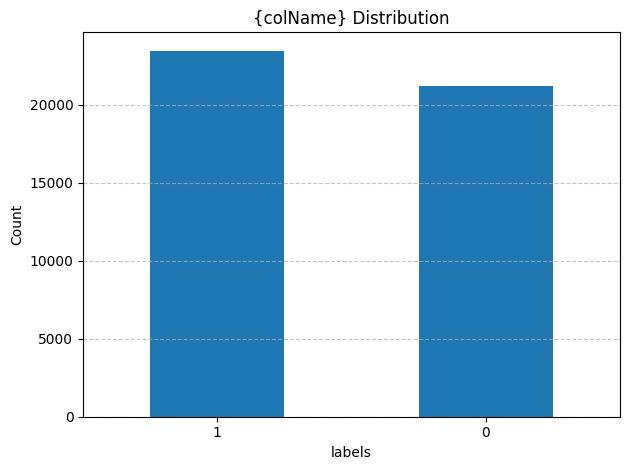

In [ ]:
explore_distribution(df_merged, 'labels')

In [77]:
def plot_length_histograms(df_input):
    """
    Plot histograms of title and text lengths grouped by label.
    """
    df = df_input.copy()
    
    df['title_len'] = df['title'].astype(str).apply(len)
    df['text_len'] = df['text'].astype(str).apply(len)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

    for label in df['labels'].unique():
        subset = df[df['labels'] == label]
        axes[0].hist(subset['title_len'], bins=50, alpha=0.5, label=label)
    axes[0].set_title("Comprimento do título por veracidade")
    axes[0].set_xlabel("Title Length")
    axes[0].set_ylabel("Count")
    axes[0].legend(title="Fake")
    axes[0].grid(True, linestyle='--', alpha=0.6)

    for label in df['labels'].unique():
        subset = df[df['labels'] == label]
        axes[1].hist(subset['text_len'], bins=50, alpha=0.5, label=label)
    axes[1].set_title("Comprimento do texto por veracidade")
    axes[1].set_xlabel("Text Length")
    axes[1].set_ylabel("Count")
    axes[1].legend(title="Fake")
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

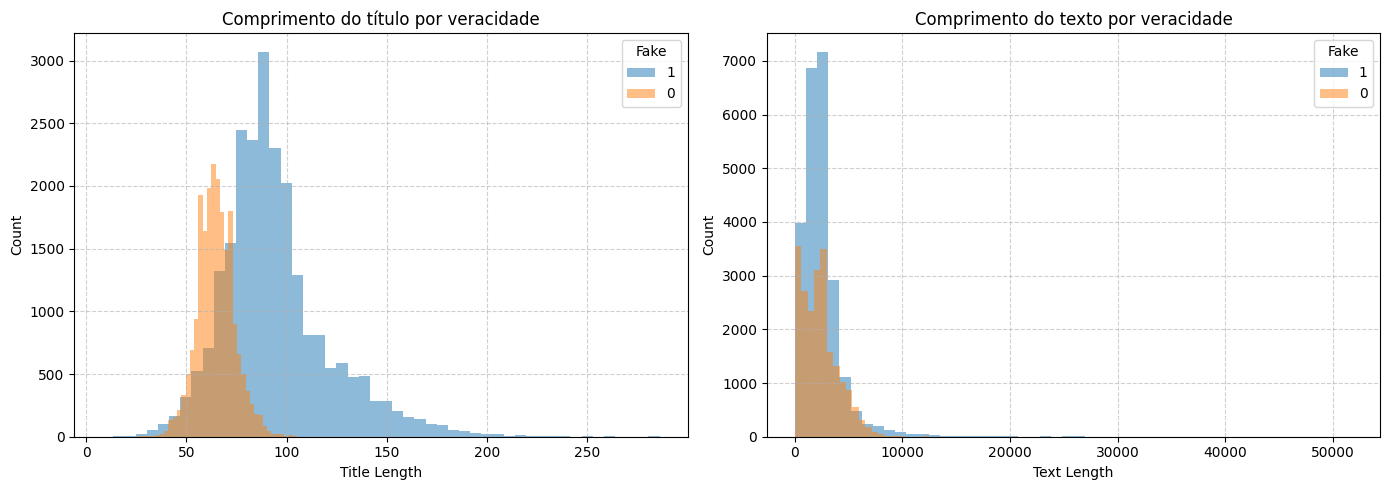

In [78]:
plot_length_histograms(df_merged)

In [79]:
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def plot_common_words(df, column='text', top_n=30):
    """
    Plot most common words in a text column by label ('fake' vs 'true'),
    excluding stopwords.
    """
    def clean_text(text):
        tokens = re.findall(r"\b\w+\b", str(text).lower())
        filtered = [word for word in tokens if word not in stop_words]
        return filtered

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for ax, label in zip(axes, [1, 0]):
        # Filtra o dataframe sem alterar o original
        texts = df[df['labels'] == label][column].dropna().apply(clean_text)
        word_counts = Counter(word for tokens in texts for word in tokens)
        common = word_counts.most_common(top_n)
        words, counts = zip(*common)

        title = 'Fake' if label == 1 else 'True'

        sns.barplot(x=list(counts), y=list(words), ax=ax)
        ax.set_title(f"Top {top_n} Words in {column.capitalize()} ({title})")
        ax.set_xlabel("Count")
        ax.set_ylabel("Word")

    plt.tight_layout()
    plt.show()

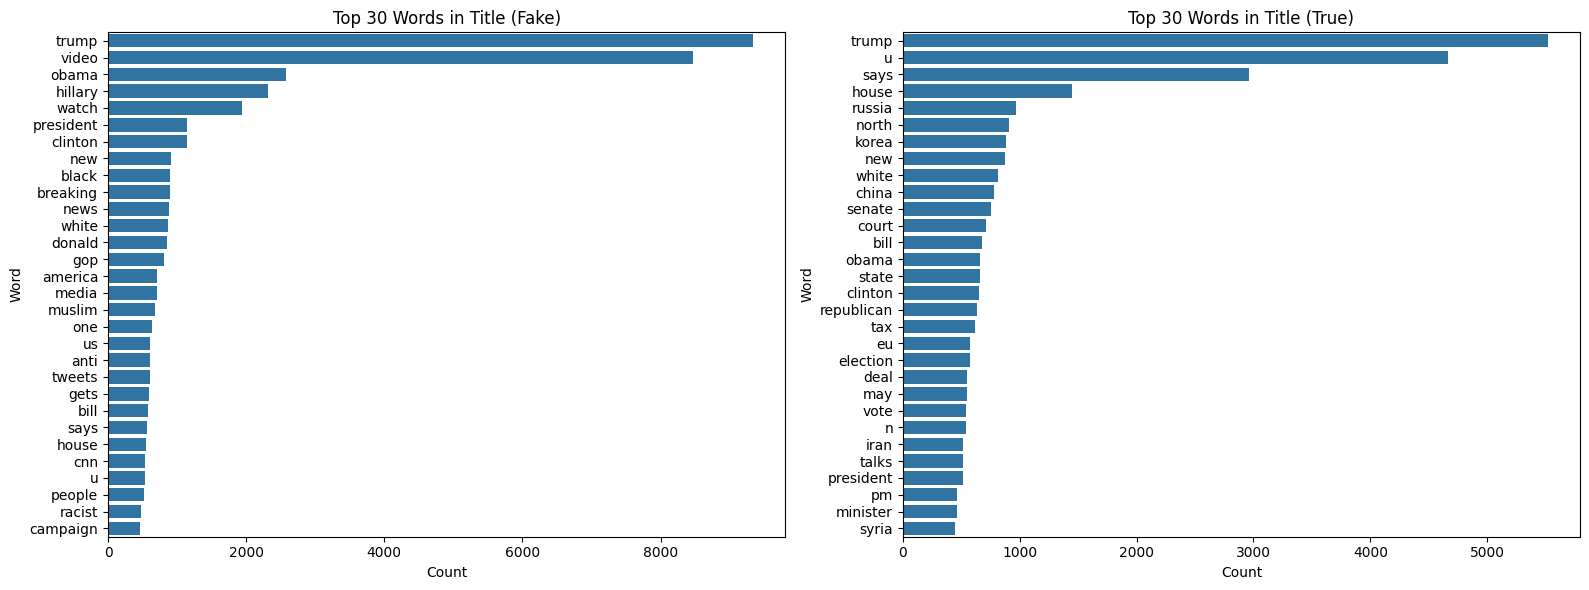

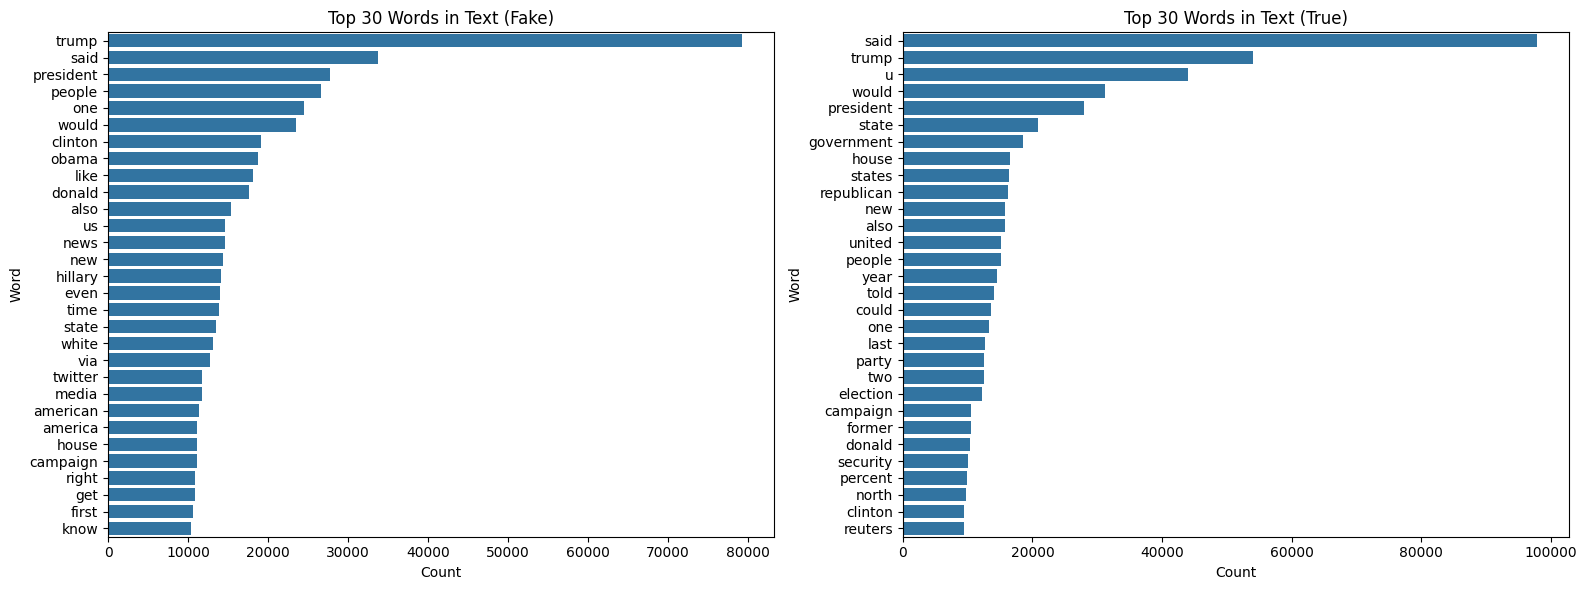

In [80]:
plot_common_words(df_merged, 'title')
plot_common_words(df_merged, 'text')

## Métricas

In [81]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    probabilities = softmax(predictions, axis=1)
    positive_class_probs = probabilities[:, 1]
    
    auc = np.round(roc_auc_score(labels, positive_class_probs), 3)
    predicted_classes = np.argmax(probabilities, axis=1)
    acc = np.round(accuracy_score(labels, predicted_classes), 3)
    
    return {"Accuracy": acc, "AUC": auc}

## BERT

In [82]:
# Split treino + teste
df_train, df_test = train_test_split(df_merged, test_size=0.4, random_state=42, stratify=df_merged['labels'])

# Split treino + validação
df_train, df_val = train_test_split(df_train, test_size=0.5, random_state=42, stratify=df_train['labels'])

In [83]:
ds_train = Dataset.from_pandas(df_train)
ds_val = Dataset.from_pandas(df_val)
ds_test = Dataset.from_pandas(df_test)

ds_train = ds_train.remove_columns("__index_level_0__")
ds_val = ds_val.remove_columns("__index_level_0__")
ds_test = ds_test.remove_columns("__index_level_0__")

In [84]:
model_path = "google-bert/bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_path)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [85]:
model = AutoModelForSequenceClassification.from_pretrained(model_path, 
                                                           num_labels=2)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [86]:
# Congela todos so parâmtros do modelo bas
for name, param in model.base_model.named_parameters():
    param.requires_grad = False

# descongela camadas de pooling do modelo base -> últimas 2 camadas
for name, param in model.base_model.named_parameters():
    if "pooler" in name:
        param.requires_grad = True

In [87]:
print(type(tokenizer))
print(tokenizer.vocab_size)

<class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>
30522


In [88]:
# Tokeniza as features textuais
# insere title e text na mesma sequência
def preprocess_function(examples):
    return tokenizer(
        examples['title'],
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=256
    )

In [ ]:
tokenized_train = ds_train.map(preprocess_function, batched=True)
tokenized_test = ds_test.map(preprocess_function, batched=True)
tokenized_val = ds_val.map(preprocess_function, batched=True)

Map:   0%|          | 0/13406 [00:00<?, ? examples/s]

Map:   0%|          | 0/17876 [00:00<?, ? examples/s]

Map:   0%|          | 0/13407 [00:00<?, ? examples/s]

### Treino

In [116]:
print(sys.executable)


/home/zeus/miniconda3/envs/cloudspace/bin/python


In [ ]:
# hyperparameters
lr = 2e-4
batch_size = 8
num_epochs = 10

training_args = TrainingArguments(
    output_dir="bert-phishing-classifier_teacher",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`

In [ ]:
!pip show accelerate


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Name: accelerate
Version: 1.9.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /system/conda/miniconda3/envs/cloudspace/lib/python3.10/site-packages
Requires: huggingface_hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

## Referências

https://www.kaggle.com/code/nguyenhonganh888/fake-news-detection-a#Explore-Text
https://github.com/ShawhinT/YouTube-Blog/blob/main/LLMs/model-compression/0_train-teacher.ipynb